# Airline dataset
This notebook generates the dataset that is used to test the ARIMA model code.
See [this link](https://www.statsmodels.org/v0.13.0/examples/notebooks/generated/statespace_sarimax_stata.html#ARIMA-Example-3:-Airline-Model) for further details.

In [1]:
%matplotlib inline

In [2]:
import requests
from io import BytesIO
from statsmodels.tsa.statespace.sarimax import SARIMAX
import pandas as pd
import numpy as np
from datetime import datetime
from dateutil.relativedelta import relativedelta
import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, r2_score
import pickle

In [3]:
base_url = 'https://www.stata-press.com/data/r12/air2.dta'
air2 = requests.get(base_url).content
data = pd.read_stata(BytesIO(air2))

In [4]:
print(data)

     air         time      t
0    112  1949.000000    1.0
1    118  1949.083374    2.0
2    132  1949.166626    3.0
3    129  1949.250000    4.0
4    121  1949.333374    5.0
..   ...          ...    ...
139  606  1960.583374  140.0
140  508  1960.666626  141.0
141  461  1960.750000  142.0
142  390  1960.833374  143.0
143  432  1960.916626  144.0

[144 rows x 3 columns]


Set the data index as a timestamp

In [5]:
data.index = pd.date_range(start=datetime(int(data.time[0]), 1, 1), periods=len(data), freq="MS")

In [6]:
print(data)

            air         time      t
1949-01-01  112  1949.000000    1.0
1949-02-01  118  1949.083374    2.0
1949-03-01  132  1949.166626    3.0
1949-04-01  129  1949.250000    4.0
1949-05-01  121  1949.333374    5.0
...         ...          ...    ...
1960-08-01  606  1960.583374  140.0
1960-09-01  508  1960.666626  141.0
1960-10-01  461  1960.750000  142.0
1960-11-01  390  1960.833374  143.0
1960-12-01  432  1960.916626  144.0

[144 rows x 3 columns]


Take the log of the time-series.
This is done to remove the exponential variance.

In [7]:
data["lnair"] = np.log(data["air"])

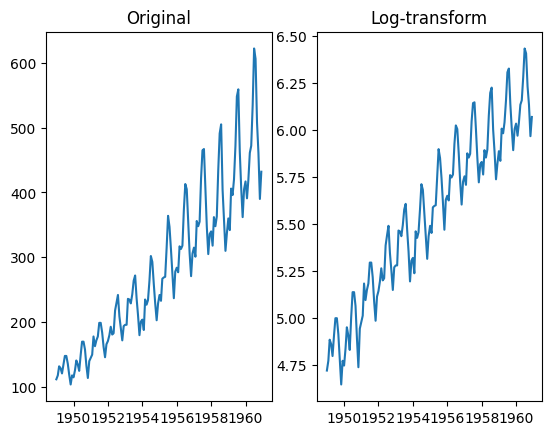

In [8]:
fig, (ax0, ax1) = plt.subplots(1, 2)
ax0.plot(data.index, data.air)
ax0.set_title("Original")
ax1.plot(data.index, data.lnair)
ax1.set_title("Log-transform")
plt.show()

We will use 80% of the data for training the ARIMA model and hold 20% as the external validation/testing set.
We will compute model metrics (root-mean-squared-error and R2 score) on this external validation set.

In [9]:
train_fraction = 0.8
n_obs = len(data)
n_obs_test = int(n_obs * (1-train_fraction))

In [10]:
print("Number of data points used in testing: ", n_obs_test)
print("Total number of data points: ", n_obs)
print("Fraction of data points used in testing: ", n_obs_test/n_obs)

Number of data points used in testing:  28
Total number of data points:  144
Fraction of data points used in testing:  0.19444444444444445


In [11]:
train_index = list(range(n_obs-n_obs_test))
test_index = list(range(n_obs-n_obs_test, n_obs))

In [12]:
# fit the ARIMA model on train data
# these parameters are taken directly from:
# https://www.statsmodels.org/v0.13.0/examples/notebooks/generated/statespace_sarimax_stata.html#ARIMA-Example-3:-Airline-Model
order = (2, 1, 0)
seasonal_order = (1, 1, 0, 12)
model = SARIMAX(data["lnair"].iloc[train_index], order=order, seasonal_order=seasonal_order)
model_fit = model.fit(disp=False)

/Users/dsalvadorjasin/Documents/projects/CROP/crop/models/arima_python/.venv2/lib/python3.11/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [13]:
print(model_fit.summary())

                                     SARIMAX Results                                      
Dep. Variable:                              lnair   No. Observations:                  116
Model:             SARIMAX(2, 1, 0)x(1, 1, 0, 12)   Log Likelihood                 187.483
Date:                            Mon, 27 Feb 2023   AIC                           -366.966
Time:                                    10:13:19   BIC                           -356.427
Sample:                                01-01-1949   HQIC                          -362.697
                                     - 08-01-1958                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3419      0.093     -3.669      0.000      -0.525      -0.159
ar.L2         -0.0196      0.113   

Get the in-sample predicitons and plot against the train data

In [14]:
predictions = model_fit.predict(
    start=data.iloc[train_index].index[0],
    end=data.iloc[train_index].index[-1]
)

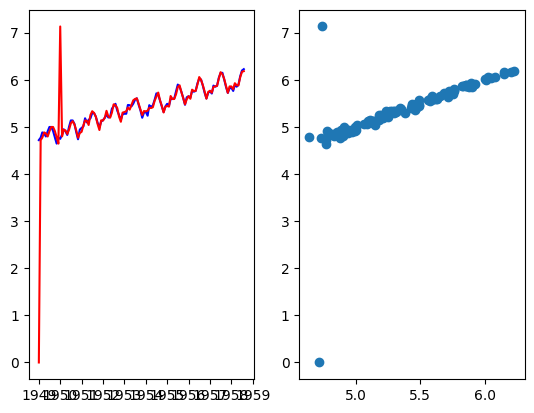

In [15]:
fig, ax = plt.subplots(1, 2)
ax[0].plot(data.iloc[train_index].index, data["lnair"].iloc[train_index], "b-")
ax[0].plot(predictions.index, predictions.values, "r-")
ax[1].scatter(data["lnair"].iloc[train_index], predictions.values)

Now produce forcasts for the test data

In [16]:
forecasts = model_fit.get_forecast(
    steps=data.iloc[test_index].index[-1]).summary_frame()

In [17]:
forecasts.head()

lnair,mean,mean_se,mean_ci_lower,mean_ci_upper
1958-09-01,6.073284,0.038659,5.997514,6.149054
1958-10-01,5.926305,0.046278,5.835601,6.017009
1958-11-01,5.799717,0.054722,5.692465,5.906969
1958-12-01,5.907846,0.061549,5.787212,6.028479
1959-01-01,5.927308,0.067807,5.794408,6.060207


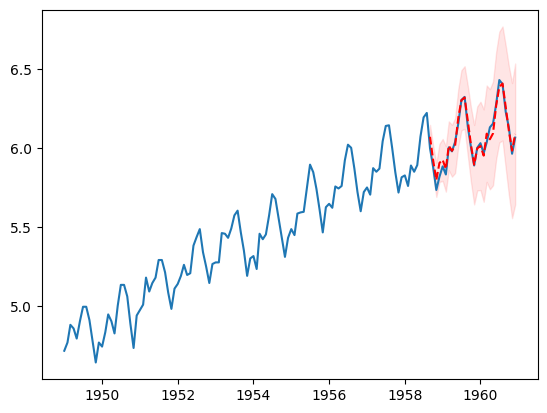

In [18]:
fig, ax = plt.subplots()
ax.plot(data.index, data.lnair)
ax.plot(forecasts.index, forecasts["mean"], "r--")
ax.fill_between(forecasts.index, forecasts["mean_ci_lower"], forecasts["mean_ci_upper"], color="r", alpha=0.1)

Compute RMSE and R2 score

In [19]:
rmse = mean_squared_error(
    data["lnair"].iloc[test_index], forecasts["mean"], squared=False)
r2 = r2_score(data["lnair"].iloc[test_index], forecasts["mean"])
print("RMSE: {0:.2f}".format(rmse))
print("R2: {0:.2f}".format(r2))

RMSE: 0.04
R2: 0.95


Save the dataset, the in-sample predictions, the forecasts, etc. to a .pkl file

In [20]:
airline_dataset = {
    "dataset": data,
    "predictions": predictions,
    "forecasts": forecasts,
    "train_index": train_index,
    "test_index": test_index,
    "rmse_forecasts": rmse,
    "r2_forecats": r2,
}
with open("tests/data/airline_dataset_arima.pkl", "wb") as handle:
    pickle.dump(airline_dataset, handle)

Create a README.md file to explain the contents of the file

In [21]:
%%writefile tests/data/README.md

## Airline Dataset
The file `airline_dataset_arima.pkl` contains an airline dataset downloaded from: 'https://www.stata-press.com/data/r12/air2.dta'.
It is used to test the ARIMA code.
An ARIMA time series model is fit to the data.
Details can be found in this notebook: `../../prepare_airline_dataset.ipynb`.

More specifically, the pickle file contains a dictionary with keys:
 - `dataset`: the airline dataset/time-series, as a pandas DataFrame
 - `predictions`: in-sample predictions of the ARIMA model fitted using train data (the first 80% of the airline time-series), as a pandas Series
 - `forecasts`: out-of-sample forecasts of the test data (the last 20% of the airline time-series), as a pandas DataFrame
 - `train_index`: a list containing the indeces of the observations of the airline time-series used for model training
 - `test_index`: a list containing the indeces of the observations of the airline time-series used for model testing
 - `rmse_forecasts`: the root-mean-square-error of the forecasts of test data
 - `r2_forecasts`: the R2 score of the forecasts of test data

Overwriting tests/data/README.md
